# Poisson process fit to start times

Import packages & configure plots for dark mode:

In [2]:
from preprocessing import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from matplotlib.ticker import FuncFormatter
plt.style.use("dark_background") # Config plots for dark mode, delete if on light mode
plt.rcParams['figure.dpi'] = 150 # Hi-res plots

In [3]:
rates_dict_train

{1: 0.08455130990453479,
 2: 0.289621632367675,
 3: 0.08187994094836117,
 4: 0.10212602763098198,
 5: 0.30638489248889395,
 6: 0.20411660999916484,
 7: 0.14812251238465612,
 8: 0.35974355787762663,
 9: 0.15278940203497143,
 10: 0.14496251010758543,
 11: 0.14163154446180637,
 12: 0.13574643044559784,
 13: 0.09956859832000972,
 14: 0.47236414357698686,
 15: 0.13288924530338184,
 16: 0.15571519786345028,
 17: 0.2481897878373756,
 18: 0.3552523914560056,
 19: 0.05718282180412813,
 20: 0.07941699405418295,
 22: 0.18606395307049056,
 23: 0.07934165686324679,
 24: 0.16689373128348584,
 25: 0.16452343241235762,
 26: 0.1140239249641807,
 27: 0.11834488585994202,
 28: 0.234450950908219,
 29: 0.1935878634343451,
 30: 0.14280490983227626,
 31: 0.20791487322928823,
 32: 0.24444334319889496,
 33: 0.22188411970288605,
 34: 0.12011346725484039,
 36: 0.23032537857929392,
 37: 0.2148662406249319,
 38: 0.12609050350673054,
 39: 0.3992667167374808,
 40: 0.198019793172133,
 41: 0.08241647528320784,
 42: 0.

Calculate and display the outliers in the rates:

In [4]:
rates = list(rates_dict_train.values())
cutoff = np.mean(rates) + 1.5*np.std(rates) # clearly nothing at minus 1.5sigma
max_rate = max(rates)
max_keys = [key for key, val in rates_dict_train.items() if val >= cutoff]
outliers = [get_station_name(i) for i in max_keys]
len(outliers)

44

In [5]:
np.mean(rates)

0.1993366122282518

Calculate the p-values for the different stations using the inter arrival times and the exponential distribution:

In [6]:
p_values = {}
for station in test_sorted_stations:
    station_id = station.start_id.unique()[0]
    if station_id in test_sorted_start_ids:
        rate = rates_dict_train[station_id]
        inter_arrival_times = station.start_time.diff().to_numpy() 
        inter_arrival_times[0] = station.start_time.to_numpy()[0] # change first inter-arrival time to t_1
        station_p_values = np.exp(-1* rate * inter_arrival_times)
        p_values[station_id] = station_p_values

Histogram of the p-values:

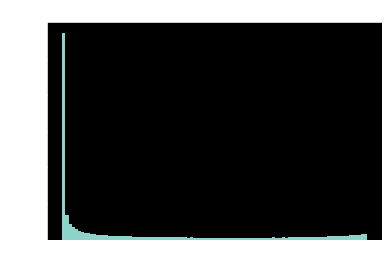

In [7]:
joined_p_values = np.concatenate(np.array(list(p_values.values()), dtype=object))
n, bins, patches = plt.hist(joined_p_values, bins=100)
ax = plt.gca()
def lblFormat(n, pos):
    return str(int(n / 1e3))
lblFormatter = FuncFormatter(lblFormat)
ax.yaxis.set_major_formatter(lblFormatter)
plt.title("Histogram of p-values for all stations")
plt.xlabel("P-value")
plt.ylabel("Counts (Thousands)")
plt.savefig("../figures/p-values.png")
plt.show()

Carry out and plot the Kolmogorov-Smirnov test on all the p-values to see if the poisson point process model is a good model for our data:

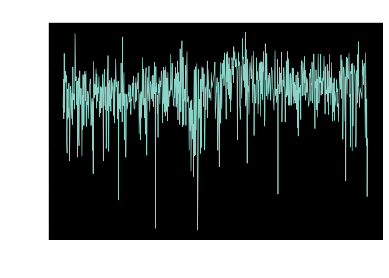

In [8]:
# Kolmogorov-smirnov:
kol_smir_test = {}
for station_id, pvals in p_values.items():
    kol_smir_test[station_id] = st.kstest(pvals, "uniform").statistic

plt.plot(kol_smir_test.keys(), kol_smir_test.values(), linewidth=0.7)
plt.title("Kolmogorov-Smirnov test for all stations")
plt.xlabel("Station Id")
plt.ylabel("$D_n$")
plt.savefig("../figures/kol-smir.png")
plt.show()

In [9]:
popularity_dict = {}
for station_id in p_values.keys():
    popularity_dict[station_id] = len(test_bike_data[test_bike_data.start_id == station_id])


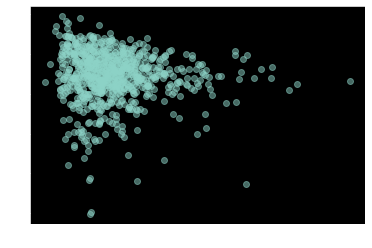

In [10]:
plt.scatter(popularity_dict.values(), kol_smir_test.values(), alpha=0.5)
plt.show()

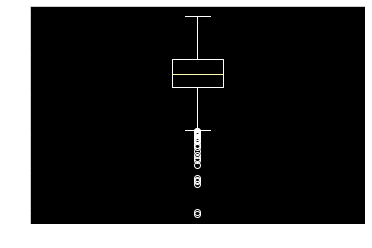

In [11]:
plt.boxplot(kol_smir_test.values())
plt.show()

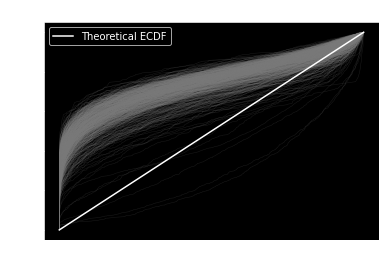

In [12]:
def ecdf(data): # https://cmdlinetips.com/2019/05/empirical-cumulative-distribution-function-ecdf-in-python/
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

for station, pvals in p_values.items():
    x,y = ecdf(pvals)
    plt.plot(x,y, alpha=0.2, linewidth=0.5, color="gray")

plt.title("ECDF for p-values")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], color="white", label="Theoretical ECDF")
plt.legend()
plt.show()